# Mean Field approximation

The effective magnetic field felt by the spins is comprised of the external field $b$ and the mean field $2jm_{mf}$ induced by neighboring particles. We have $b_{eff}= b+ 2jm$.

Therefore, we obtain a magnetisation $m = tanh(b_{eff}) = tanh(b + 2jm)$.

This is a transcendental equation. We can solve it graphically by plotting $tanh(b + 2jm)$ over $m$ for fixed values of $b$ and $j$.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
from numpy.random import rand

%matplotlib inline

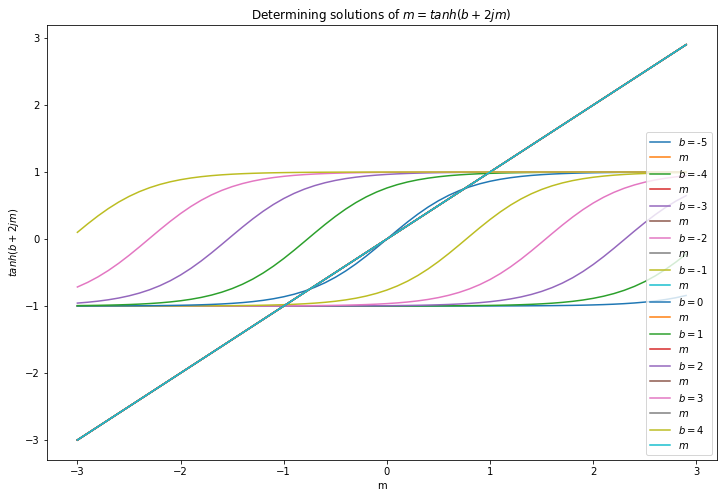

In [21]:
j = 0.65

#magnetisation
def magn(b,m):
    return np.tanh(b + 2*j*m)


#Plot
m = np.arange(-3,3,0.1)
b = np.arange(-5,5,1)
plt.figure(figsize = (12, 8))

for i in b:
    plt.plot(m,magn(i,m), label = '$b=$'+str(i))
    plt.plot(m,m, label = '$m$')
    plt.title('Determining solutions of $ m = tanh(b+2jm)$')
    plt.xlabel('m')
    plt.ylabel('$tanh(b + 2jm)$')
    plt.grid()
    plt.legend(loc='lower right')
    
plt.show()

For every value of $b$, the solution to the equation $m = tanh(b+2jm)$ corresponds to the intersection points between both graphs. Plotting these against $b$ results in the following:

# Metropolis Algorithm

The Metropolis Algorithm is a manner to determine the average magnetisation and energy of a lattice. These quantities are defined as follows:

$m= \frac{1}{N} \sum_{i}^{states} w(S_i) M_i$

where $w(S_i)$ is the probability distribution for a spin state $S_i$.

In the same manner, 
$E= \frac{1}{N} \sum_{i}^{states} w(S_i) E_i$

In general, we determine the energy of a spin state using
$h(S_i) = -b \sum_{\alpha}^{atoms} s_{\alpha} - \frac{j}{2} s_{\alpha} \sum_{\beta}^{4} s_{\beta}$

where $b=\frac{B}{\beta}$ is the external magnetic field, $j = \frac{J}{\beta}$ is the nearest neighbour's coupling constant, $h=\frac{E}{\beta}$ the energy of a spin state and the last sum is only involving the neighbouring atoms of $s_{\alpha}$

However, the probability distribution $w(S_i)$ is extremely difficult to find. Therefore, one uses the Metropolis algorithm to determine the spin states with highest probabilities, which dominate the results of the above sums. It works as follows:

1. Generation of a Random Spin Configuration
2. For every atom in the lattice, we choose whether to flip the spin or not. We do so, by determining the energy difference between both spin states. It is determined by 

$\delta h = h(s_{\alpha}*) - h(s_\alpha) = s_\alpha (2b + j \sum_{\beta}^{4} s_{\beta})$.

If the energy of the new state is lower than that of the old one, the probability of accepting the new spin is one. However, if the opposite is the case, then the probability to keep the new spin is $exp(-\delta h)$.


3. For every new Spin configuration the mean magntic moment and mean energy is calculated
4. This process is repeated a few hundred times, yielding a set of spin configurations with highest probability
5. Knowing the energies and magnetisations of the most probable spin configurations, we can use these to determine the average magnetisation and energy of a lattice as follows:

$m = \frac{1}{N_s}\sum_{i}^{sweeps} m(S_i)$

$h = \frac{1}{N_s}\sum_{i}^{sweeps} h(S_i)$

where we divide by the number of sweeps $N_s$

In [64]:
#1. Generation of a random spin configuration for a lattice of NxN atoms
def initialstate(N):   
    ''' generates a random spin configuration for initial condition'''
    state = 2*np.random.randint(2, size=(N,N))-1
    return state

In [65]:
#2. Creating a new spin configuration by moving from one atom of the lattice to the other, and choosing whether to flip the spin, or not
def randconfig(config,j,b):
    for x in range(N):
        for y in range(N):
            #moving to each atom
            s =  config[x, y]
            
            #defining the total spin of the atom's neighbours for energy calculation
            nb = config[(x+1)%N,y] + config[x,(y+1)%N] + config[(x-1)%N,y] + config[x,(y-1)%N]
            
            #determining energy difference del(E) between actual spin state and that of an opposite spin.
            # if del(E)<0, flip the spin
            # if del(E)>0, flip the spin with probability exp(-del(h))
        
            delE = s*(2*b + j*nb)
            if delE < 0:
                s *= -1
            elif rand() < np.exp(-delE):
                s *= -1
            config[x, y] = s
    return config

In [66]:
#Calculating the energy of a configuration

def calcEnergy(config):
    '''Energy of a given configuration'''
    energy = 0
    for i in range(len(config)):
        for j in range(len(config)):
            s = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N]
            energy += -j*s*nb/2. # calculating energy through neighbour interaction
    energy += -b*np.sum(config) # adding energy through external field
    return energy

In [67]:
#calculating the magnetisation of a configuration

def calcMag(config):
    '''Magnetization of a given configuration'''
    mag = np.sum(config)
    return mag

Text(0.5, 1.0, 'Mean magnetisation at $j=0.2$')

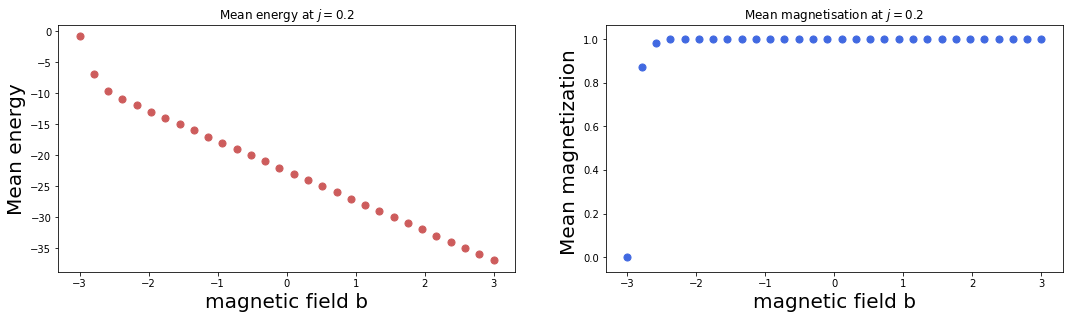

In [78]:
#Implementing the alorithm

# defining parameters
N = 5 # lattice size
j = 0.2 # nearest neighbour's interaction strength
nb = 30 # number of different values of b
eqSteps = 1024 # number of sweeps for equilibration
mcSteps = 1024 # number of sweeps for calculation

binterv = np.linspace(-3, 3, nb); 
E,M = np.zeros(nb), np.zeros(nb)
n  = 1.0/(N*N*mcSteps) #dividing by system size to get mean values

#implementing the algorithm

for b in range(nb):
    e = m = 0
    config = initialstate(N)
    
    for i in range(eqSteps):         # thermalise
        randconfig(config, j, b)           # creating random configurations

    for i in range(mcSteps):
        randconfig(config, j,b)           
        Ene = calcEnergy(config)     # calculate the energy
        Mag = calcMag(config)        # calculate the magnetisation

        e += Ene   #calculating sum of energy values for each configuration
        m += Mag   #calculating sum of magnetisation values for each configuration
    
    #normalising values
    E[b] = n*e 
    M[b] = n*m
    
    
#Plotting results

f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 );
plt.scatter(binterv, E, s=50, marker='o', color='IndianRed')
plt.xlabel("magnetic field b", fontsize=20);
plt.ylabel("Mean energy", fontsize=20);         plt.axis('tight');
plt.title("Mean energy at $j=0.2$")

sp =  f.add_subplot(2, 2, 2 );
plt.scatter(binterv, M, s=50, marker='o', color='RoyalBlue')
plt.xlabel("magnetic field b", fontsize=20); 
plt.ylabel("Mean magnetization ", fontsize=20);   plt.axis('tight');
plt.title("Mean magnetisation at $j=0.2$")

In [ ]:
#Implementing the alorithm

# defining parameters
N = 5 # lattice size
j = 0.8 # nearest neighbour's interaction strength
nb = 30 # number of different values of b
eqSteps = 1024 # number of sweeps for equilibration
mcSteps = 1024 # number of sweeps for calculation

binterv = np.linspace(-3, 3, nb); 
E,M = np.zeros(nb), np.zeros(nb)
n  = 1.0/(N*N*mcSteps) #dividing by system size to get mean values

#implementing the algorithm

for b in range(nb):
    e = m = 0
    config = initialstate(N)
    
    for i in range(eqSteps):         # thermalise
        randconfig(config, j, b)           # creating random configurations

    for i in range(mcSteps):
        randconfig(config, j,b)           
        Ene = calcEnergy(config)     # calculate the energy
        Mag = calcMag(config)        # calculate the magnetisation

        e += Ene   #calculating sum of energy values for each configuration
        m += Mag   #calculating sum of magnetisation values for each configuration
    
    #normalising values
    E[b] = n*e 
    M[b] = n*m
    
#Plotting results

f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 );
plt.scatter(binterv, E, s=50, marker='o', color='IndianRed')
plt.xlabel("magnetic field b", fontsize=20);
plt.ylabel("Mean energy", fontsize=20);         plt.axis('tight');
plt.title("Mean energy at $j=0.2$")

sp =  f.add_subplot(2, 2, 2 );
plt.scatter(binterv, M, s=50, marker='o', color='RoyalBlue')
plt.xlabel("magnetic field b", fontsize=20); 
plt.ylabel("Mean magnetization ", fontsize=20);   plt.axis('tight');
plt.title("Mean magnetisation at $j=0.8$")